# Lasso Regression

# Gradient Descent Algorithm

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.append("ML_2024-25/Esercizi/")
from utils import plot_gradient_1d, plot_gradient_2d, plot_derivative

In [69]:
np.random.seed(0)

def f(x):
    return (x ** 2) * 0.1

def df(x): # derivata di f
    return (2 * x) * 0.1


"""
    Plot the derivative of a function as vectors along the function.
    ### Parameters
    - `f` (function): function to plot
    - `df` (function): derivative of the function
    - `x` (array-like): range of x values to plot
    - `t` (str | None): title of the plot, optional
    - `n` (int): number of points to plot the derivative at
"""
plot_derivative(f, df, t = "Quadratic function")



In [70]:
# provo con la funzione seno
plot_derivative(np.sin, np.cos, x=np.linspace(-2*np.pi, 2*np.pi, 100), t="Sine function", n=7 )

In [71]:
plot_gradient_1d(f, df, x=np.linspace(-10, 10, 100), n=10)

# Provo: Aumento le dimensioni

In [72]:
def f(x1, x2):
    return (x1**2 + x2**2) * 0.1

# this time the function has two variables, so we need to calculate the partial derivatives
def df(x1, x2):
    return np.array([2*x1, 2*x2]) * 0.1

plot_gradient_2d(f, df, follow_surface=False)

In [73]:
lambda_ = 10

def f_lasso(x1, x2):
    mse = (x1**2 + x2**2)
    penalty = lambda_ * (np.abs(x1) + np.abs(x2))
    return 0.1 * (mse + penalty)

def df_lasso(x1, x2):
    d_mse = np.array([2*x1, 2*x2])
    d_penalty = lambda_ * np.array([np.sign(x1), np.sign(x2)])
    return 0.1 * (d_mse + d_penalty)

plot_gradient_2d(f_lasso, df_lasso, follow_surface=False)

# LASSO

In [74]:
def create_dataset():
    np.random.seed(0)
    n_features = 3
    n_samples = 100
    X = np.random.randn(n_samples, n_features)
    X_expanded = np.hstack([np.ones((n_samples, 1)), X])
    beta_true = [1, 2, 3, 4]
    y = X_expanded @ np.array(beta_true) + np.random.randn(n_samples)
    y = np.reshape(-1, 1)

    return X, y

def lasso_gradient(X, y, beta, lambda_):
    beta = 2 * X.T @ (X @ beta - y)
    L1 = lambda_ * np.sign(beta)
    L1[0] = 0
    return beta + L1

def update_weights(beta, learning_rate, gradient):
    return beta - learning_rate * gradient

def compute_mse(X, beta, y):
    return np.mean((y - X @ beta)**2)

def train_LASSO_with_GD(X_train, y_train, lambda_, learning_rate, max_iter, tol):
    """
    Optimize the Lasso objective function using gradient descent.

    Parameters
    ----------
    X_train : ndarray of shape (n_samples, n_features + 1)
        The matrix of input features, where features are already standardized.
    y_train : ndarray of shape (n_samples, 1)
        The vector of true target values
    lambda_ : float
        The regularization parameter.
    learning_rate : float
        The learning rate for gradient descent (alpha)
    max_iter : int
        The maximum number of iterations.
    tol : float
        The stopping criterion. The algorithm stops when the euclidean distance of the difference between the current beta and the previous beta is less than tol.
    """

    # expand the feature matrix X with a column of ones for the intercept term
    n_samples, n_features = X_train.shape
    X_train = np.hstack([np.ones((n_samples, 1)), X_train])             # add a column of ones to the left of X

    beta = np.random.randn(n_features+1, 1) # initialize β with random normal values. We include the intercept term in β. Il +1 è il bias.
    i = 0
    beta_difference = tol + 1 # condizione per cui uscire dal loop. tol -> tolerance
    while i < max_iter and beta_difference > tol:

        gradient = lasso_gradient(X_train, y_train, beta, lambda_) # calcolo del gradiente

        beta_new = update_weights(beta, learning_rate, gradient) # aggiornamento di beta
        beta_difference = np.linalg.norm(beta_new - beta)               # to check the stopping criterion
        beta = beta_new
        i = i + 1                                                          # increment the iteration counter
    return beta

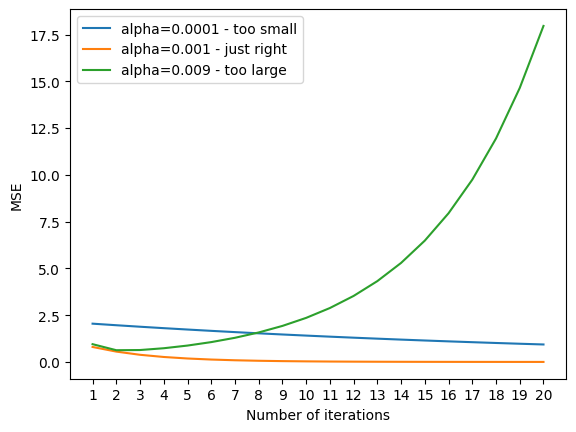

In [75]:
# creo il dataset 
X, y = create_dataset()
n_samples, n_features = X.shape
X_expanded = np.hstack([np.ones((n_samples, 1)), X]) 

# Learning rates to test
alphas = [0.0001, 0.001, 0.009]  # too small, just right, too large
lambda_ = 0.1
tol = 1e-6
max_iter = 20 #POCHE ITERAZIONI

# TRAIN
all_errors = []
for learning_rate in alphas:
    errors = []
    beta = np.random.randn(n_features + 1, 1)
    i = 0
    beta_diff = tol + 1
    while i < max_iter and beta_diff > tol:
        gradient = lasso_gradient(X_expanded, y, beta, lambda_)
        beta_new = update_weights(beta, learning_rate, gradient)
        beta = beta_new
        error = compute_mse(X_expanded, beta, y)
        errors.append(error)
        i = i + 1
    all_errors.append(errors)


# grafico
a = np.array(all_errors)
n_iters = a.shape[1]
x = np.arange(n_iters) +1
plt.plot(x, a[0, :], label=f"alpha={alphas[0]} - too small")
plt.plot(x, a[1, :], label=f"alpha={alphas[1]} - just right")
plt.plot(x, a[2, :], label=f"alpha={alphas[2]} - too large")
plt.xticks(x)
plt.xlabel("Number of iterations")
plt.ylabel("MSE")
plt.legend()

# Nested Cross Validation

In [76]:
# 1) Carico dati

data = pd.read_csv("prostate.csv")
display(data.head())

X = data.drop(columns=["lpsa"]).to_numpy()
y = data[["lpsa"]].to_numpy()

print("X.shape:", X.shape)
print("y.shape:", y.shape)

n_samples = X.shape[0]
n_features = X.shape[1]

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564


X.shape: (96, 8)
y.shape: (96, 1)


In [77]:
# 2) Combinazione degli iperparametri

alphas = [0.00001, 0.0001, 0.001, 0.01]
lambdas_ = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
hyperparams_comb = [(alpha, lambda_) for alpha in alphas for lambda_ in lambdas_]

print("Number of alphas:", len(alphas))
print("Number of lambdas:", len(lambdas_))
print("Number of hyperparameters combinations:", len(hyperparams_comb))
print("Hyperparameters combinations:", hyperparams_comb)

Number of alphas: 4
Number of lambdas: 7
Number of hyperparameters combinations: 28
Hyperparameters combinations: [(1e-05, 0.0001), (1e-05, 0.001), (1e-05, 0.01), (1e-05, 0.1), (1e-05, 1), (1e-05, 10), (1e-05, 100), (0.0001, 0.0001), (0.0001, 0.001), (0.0001, 0.01), (0.0001, 0.1), (0.0001, 1), (0.0001, 10), (0.0001, 100), (0.001, 0.0001), (0.001, 0.001), (0.001, 0.01), (0.001, 0.1), (0.001, 1), (0.001, 10), (0.001, 100), (0.01, 0.0001), (0.01, 0.001), (0.01, 0.01), (0.01, 0.1), (0.01, 1), (0.01, 10), (0.01, 100)]


In [78]:
# 3) Divisione dei dati

K = 8
fold_size = n_samples // K

shuffled_indices = np.random.permutation(n_samples)
X_shuffled = X[shuffled_indices]
y_shuffled = y[shuffled_indices]

In [ ]:
# 4) Per ogni fold

n_max_iter_GD = 1000
mse_values = []             # to store performance values across folds
r2_values = []              # to store performance values across folds

for i in range(K):
    # seleziono test_set e training_set
    start_test = i * fold_size
    end_test = (i + 1) * fold_size
    X_test = X_shuffled[start_test:end_test]
    y_test = y_shuffled[start_test:end_test]
    X_train = np.concatenate([X_shuffled[:start_test], X_shuffled[end_test:]])
    y_train = np.concatenate([y_shuffled[:start_test], y_shuffled[end_test:]])

    # itero tutte le possibili combinazioni degli iperparametri per prendere il migliore
    best_combination = (0, 0)
    best_mse = np.inf

    # per selezionare i migliori iperparametri
    for alpha, lambda_ in hyperparams_comb: 
        D = 4
        n_samples_in_X_train = X_train.shape[0]
        D_fold_size = n_samples_in_X_train // D

        mse_inner_values = []

        for j in range(D):
            # a. take j-th fold as validation set and the rest as training set
            start_val = j * D_fold_size
            end_val = (j + 1) * D_fold_size
            X_val = X_train[start_val: end_val]
            y_val = y_train[start_val:end_val]
            X_inner_train = np.concatenate([X_train[:start_val], X_train[end_val:]])
            y_innter_train = np.concatenate([y_train[:start_val], y_train[end_val:]])

            # standardize the data (using the X_inner_train set)
            X_inner_train_mean = np.mean(X_inner_train, axis=0)
            X_inner_train_std = np.std(X_inner_train, axis=0)
            X_inner_train = (X_inner_train - X_inner_train_mean) / X_inner_train_std
            X_val = (X_val - X_inner_train_mean) / X_inner_train_std

            # b. Find the coefficients of the LASSO model using the inner training set + the current hyperparameters combination
            beta_ = train_LASSO_with_GD(X_inner_train, y_innter_train, lambda_, alpha, n_max_iter_GD, 1e-6)

            # c. Evaluate the model on the validation set
            y_val_pred = beta_[0] + X_val @ beta_[1:]
            mse = np.mean((y_val - y_val_pred)**2)
            mse_inner_values.append(mse)

        # 5. Select the best hyperparameters combination based on the average performance on the validation set
        best_alpha, best_lambda_ = best_combination
        print("Best hyperparameters combination for iteration ", i, " is: ", best_combination)

        # 6. Train LASSO using the training set + the best hyperparameters combination
        # standardize the data and add the intercept term
        X_train_mean = np.mean(X_train, axis=0)
        X_train_std = np.std(X_train, axis=0)
        X_train_scaled = (X_train - X_train_mean) / X_train_std
        X_test_scaled = (X_test - X_train_mean) / X_train_std
        X_train_scaled = np.concatenate([np.ones((X_train_scaled.shape[0], 1)), X_train_scaled], axis=1)
        X_test_scaled = np.concatenate([np.ones((X_test_scaled.shape[0], 1)), X_test_scaled], axis=1)

        beta = np.random.randn(n_features + 1, 1)
        for t in range(n_max_iter_GD):
            gradient = lasso_gradient(X_train_scaled, y_train, beta, best_lambda_)
            beta = update_weights(beta, best_alpha, gradient)

        # 7. Evaluate the model on the test set
        y_test_pred = X_test_scaled @ beta
        mse = np.mean((y_test - y_test_pred)**2)
        r2 = 1 - mse / np.var(y_test)

        mse_values.append(mse)
        r2_values.append(r2)

    # 8. Aggregate performance metrics, plot boxplots
    mse_list = np.array(mse_values)
    r2_list = np.array(r2_values)

    plt.subplot(1, 2, 1)
    plt.boxplot(mse_list)
    plt.title("MSE")
    plt.subplot(1, 2, 2)
    plt.boxplot(r2_list)
    plt.title("R2")
    plt.show()



Best hyperparameters combination for iteration  0  is:  (0, 0)


NameError: name 'GD_update' is not defined